In [1]:
import torch
from torch import nn
from d2l import torch as d2l

### 实现丢弃函数
其中 `dropout` 就是丢弃概率 `p` (以 p 概率丢弃神经元)

In [2]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1 # 保证概率值的问题
    if dropout == 1:
        return torch.zeros_like(X) # 神经元置零
    if dropout == 0:
        return X # 保持原输出
    mask = (torch.rand(X.shape) > dropout).float() # 生成一个和 X 形状相同的随机矩阵，大于 p 的为 1 ，其余为 0，最终 mask 由 0 和 1组成
    return mask * X / (1.0 - dropout) # mask 乘以 X，达到去除神经元的作用

测试一下丢弃函数

In [3]:
X = torch.arange(16, dtype=torch.float32).reshape(2, 8)
a = dropout_layer(X, 0.)
b = dropout_layer(X, 0.5)
c = dropout_layer(X, 1.0)

### 定义感知机

使用 Fashion-MNIST 数据集，定义有两个隐藏层的感知机

In [4]:
num_inputs, num_outputs, num_hidden1, num_hidden2 = 784, 10, 256, 256

In [5]:
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module): # 继承网络基类
    def __init__(self, num_inputs, num_outputs, num_hidden1, num_hidden2, is_training = True):
        super(Net, self).__init__() # 调用父类的 init 方法，确保了 Net 类正确地继承了 nn.Module 的所有属性和方法
        self.num_inputs = num_inputs # self.xxx = xxx 相当于值传递，方便在整个类中使用
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hidden1) # 分别定义 1，2，3 层
        self.lin2 = nn.Linear(num_hidden1, num_hidden2)
        self.lin3 = nn.Linear(num_hidden2, num_outputs)
        self.relu = nn.ReLU() # 定义激活函数

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape(-1, self.num_inputs))) # 将输入 X 重塑为二维张量，其中每一行是一个样本，每一列是一个张量
        if self.training == True:
            H1 = dropout_layer(H1, dropout1)# 第一隐藏层作用丢弃法
        H2 = self.relu(self.lin2(H1)) # 将第一隐藏层输出作为第二隐藏层输入并使用激活函数
        if self.training == True:
            H2 = dropout_layer(H2, dropout2) # 第二隐藏层作用丢弃法
        out = self.lin3(H2) # 输出层不做丢弃法处理
        return out

net = Net(num_inputs, num_outputs, num_hidden1, num_hidden2)

### 训练

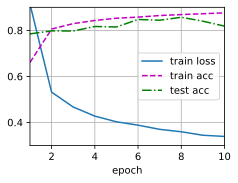

In [7]:
num_epoches, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss() #若加了 reduction='none'，会出错，原因可能是 backward() 只能对标量求，但是之前就没错，很奇怪
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epoches, trainer)

### 简洁实现

In [11]:
net = nn.Sequential(nn.Flatten(), 
                    nn.Linear(784, 256), nn.ReLU(), nn.Dropout(dropout1), # 定义一层后加需要作用的（激活函数、 丢弃）
                    nn.Linear(256, 256), nn.ReLU(), nn.Dropout(dropout2),
                    nn.Linear(256, 10)
                   )

def init_weight(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weight)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

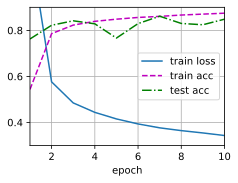

In [12]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epoches, trainer)